In [1]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from gan_tensorflow import NeuralNetwork
import helper
import tensorflow as tf

In [2]:
network = NeuralNetwork()

batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

epochs = 50

data_dir = "./data/135981"
files = glob(os.path.join(data_dir, '*.jpg'))
celeba_dataset = helper.Dataset('celeba', files)

print("Learning from {} images".format(len(files)))



Learning from 0 images


In [ ]:
import random
random.shuffle(files)
files[:10]

['./data/135981\\135981-84395-12138718.jpg',
 './data/135981\\135981-271954-12136078.jpg',
 './data/135981\\135981-1123-12278734.jpg',
 './data/135981\\135981-3063-11763685.jpg',
 './data/135981\\135981-20420-11899882.jpg',
 './data/135981\\135981-90739-11954306.jpg',
 './data/135981\\135981-175944-11229823.jpg',
 './data/135981\\135981-1511102-12175759.jpg',
 './data/135981\\135981-3060-11805128.jpg',
 './data/135981\\135981-2478-12113575.jpg']

(?, 28, 28, 3)
Epoch 1/50... Discriminator Loss: 0.0884... Generator Loss: 4.4943
Epoch 1/50... Discriminator Loss: 0.0789... Generator Loss: 4.9978


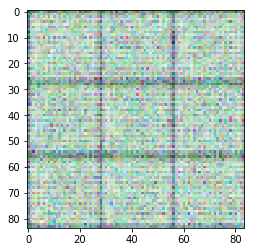

Epoch 1/50... Discriminator Loss: 0.1868... Generator Loss: 2.7715
Epoch 1/50... Discriminator Loss: 0.1901... Generator Loss: 2.7518


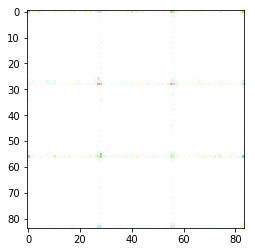

Epoch 1/50... Discriminator Loss: 0.1877... Generator Loss: 3.7373
Epoch 1/50... Discriminator Loss: 0.1162... Generator Loss: 3.5411


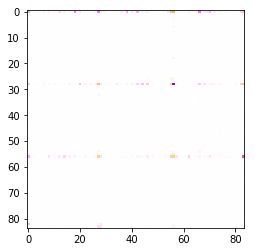

Epoch 1/50... Discriminator Loss: 1.9738... Generator Loss: 1.0326
Epoch 1/50... Discriminator Loss: 0.0809... Generator Loss: 5.5707


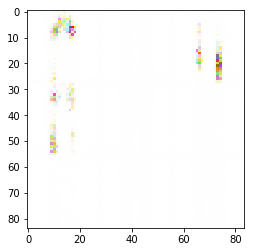

Epoch 1/50... Discriminator Loss: 0.0762... Generator Loss: 5.2799
Epoch 1/50... Discriminator Loss: 0.0760... Generator Loss: 4.8838


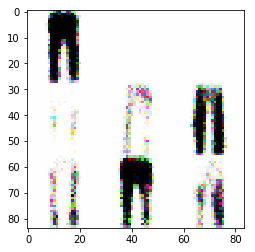

Epoch 1/50... Discriminator Loss: 0.0678... Generator Loss: 5.4137
Epoch 1/50... Discriminator Loss: 0.1260... Generator Loss: 3.5352


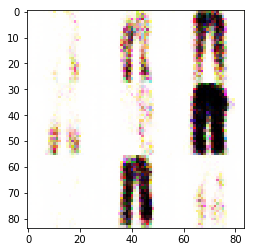

Epoch 1/50... Discriminator Loss: 0.0792... Generator Loss: 4.7776
Epoch 1/50... Discriminator Loss: 0.5327... Generator Loss: 1.9452


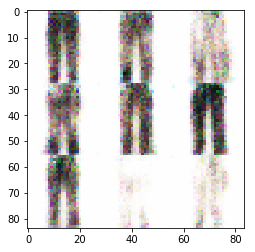

Epoch 1/50... Discriminator Loss: 0.1089... Generator Loss: 4.5007
Epoch 1/50... Discriminator Loss: 0.2076... Generator Loss: 3.0319


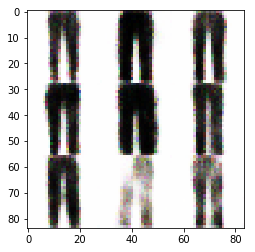

Epoch 1/50... Discriminator Loss: 0.1033... Generator Loss: 3.4654


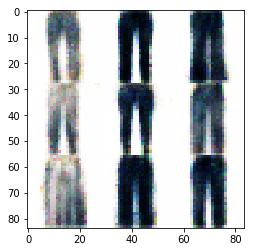

Epoch 2/50... Discriminator Loss: 0.1491... Generator Loss: 3.5493


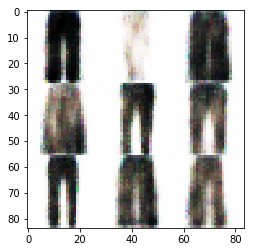

Epoch 2/50... Discriminator Loss: 0.1807... Generator Loss: 2.2051
Epoch 2/50... Discriminator Loss: 0.1566... Generator Loss: 3.3393


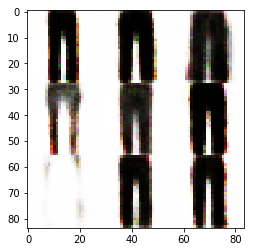

Epoch 2/50... Discriminator Loss: 0.5516... Generator Loss: 3.4903
Epoch 2/50... Discriminator Loss: 0.2271... Generator Loss: 1.5579


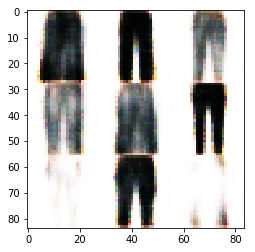

Epoch 2/50... Discriminator Loss: 0.2262... Generator Loss: 2.2383
Epoch 2/50... Discriminator Loss: 0.2817... Generator Loss: 4.0984


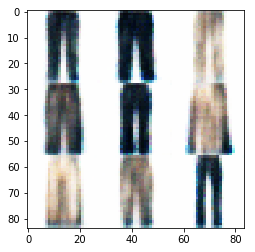

Epoch 2/50... Discriminator Loss: 0.1568... Generator Loss: 3.4185
Epoch 2/50... Discriminator Loss: 0.1373... Generator Loss: 4.1459


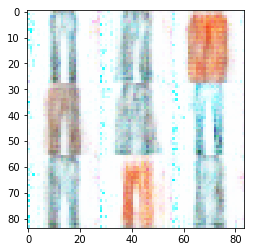

Epoch 2/50... Discriminator Loss: 1.3502... Generator Loss: 10.6584
Epoch 2/50... Discriminator Loss: 0.2034... Generator Loss: 2.8182


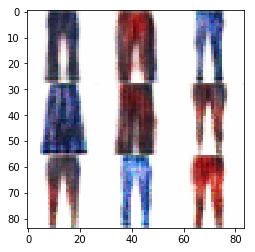

Epoch 2/50... Discriminator Loss: 0.4330... Generator Loss: 1.2647


In [ ]:
with tf.Graph().as_default():
    network.train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)
